### By Yahia Galal

## In this project, ArtAuth: AI vs Human, we will try to deploy a model to classify a piece of art as either AI or Human made

### we will use a dataset from Kaggle, in which the creator scrapped some real paintings and AI paintings from different websites on the internet

In [1]:
conda install pytorch torchvision torchaudio cpuonly -c pytorch

Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0




In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

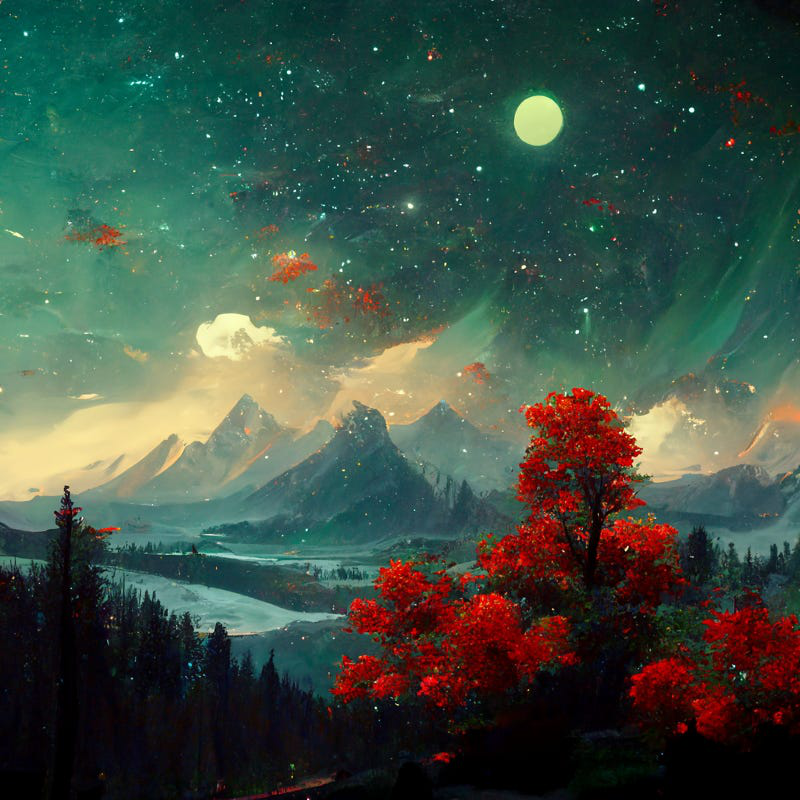

In [4]:
with Image.open('./DataSet/Train/Human/.amazonaws.com2Fpublic2Fimages2Fcb32a00a-bf52-48fe-9ba6-4e21cf4c1c57_800x800.png') as im:
    display(im)

In [5]:
path = '.\\DataSet'
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'\\'+img)
        
print('Images: ',len(img_names))

Images:  975


In [6]:
# Start by creating a list
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)
        
print(f'Images:  {len(img_sizes)}')
print(f'Rejects: {len(rejected)}')

Images:  975
Rejects: 0


In [7]:
# Convert the list to a DataFrame
df = pd.DataFrame(img_sizes)

# Run summary statistics on image widths
df[0].describe()

count     975.000000
mean     1238.334359
std       864.368176
min       183.000000
25%       700.000000
50%      1024.000000
75%      1500.000000
max      8495.000000
Name: 0, dtype: float64

In [8]:
# Run summary statistics on image heights
df[1].describe()

count     975.000000
mean      941.094359
std       717.233505
min       135.000000
25%       533.000000
50%       768.000000
75%      1080.000000
max      7091.000000
Name: 1, dtype: float64

In [9]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(256),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [10]:
from torchvision.datasets import DatasetFolder
from torch.utils.data import ConcatDataset
from torch.utils.data import Dataset

In [11]:
root = './DataSet'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)
torch.manual_seed(18)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['AI', 'Human']
Training images available: 842
Testing images available:  131


In [12]:
from torchvision.utils import make_grid

Label: [1 1 0 0 1 0 0 1 0 0]
Class: Human Human AI AI Human AI AI Human AI AI


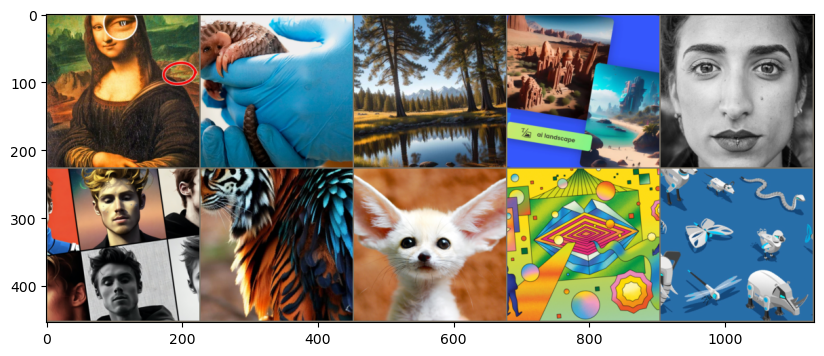

In [13]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)


# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [14]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [15]:
torch.manual_seed(18)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [16]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [17]:
count_parameters(CNNmodel)

     162
       6
     864
      16
 5598720
     120
   10080
      84
     168
       2
________
 5610222


In [18]:
import time
import copy

start_time = time.time()

epochs = 15

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []
best_predictions=[]
epoch_real_values=[]
real_values=[]

epoch_predictions=[]

best_accuracy = 0
best_model_wts = copy.deepcopy(CNNmodel.state_dict())

for epoch in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%10 == 0:
            print(f'epoch: {epoch:2}  batch: {b:4} [{10*b:6}/800]  train loss: {loss.item():10.8f}  \
train accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            epoch_predictions.extend(predicted.numpy())
            epoch_real_values.extend(y_test.numpy())
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    
    # Calculate test accuracy
    accuracy = tst_corr * 100 / (131)
    print(f'epoch: {epoch + 1:2}  test loss: {loss.item():10.8f}  test accuracy: {accuracy:7.3f}%')

    # Save the model weights if the current epoch has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_wts = copy.deepcopy(CNNmodel.state_dict())
        best_predictions=epoch_predictions
        real_values=epoch_real_values
        
    epoch_predictions=[]
    epoch_real_values=[]

# Load the best model weights
CNNmodel.load_state_dict(best_model_wts)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')  # print the time elapsed

epoch:  0  batch:   10 [   100/800]  train loss: 0.65489829  train accuracy:  53.000%
epoch:  0  batch:   20 [   200/800]  train loss: 0.57538319  train accuracy:  61.000%
epoch:  0  batch:   30 [   300/800]  train loss: 0.74128723  train accuracy:  60.000%
epoch:  0  batch:   40 [   400/800]  train loss: 0.65351093  train accuracy:  59.000%
epoch:  0  batch:   50 [   500/800]  train loss: 0.44208393  train accuracy:  58.400%
epoch:  0  batch:   60 [   600/800]  train loss: 0.57704496  train accuracy:  59.167%
epoch:  0  batch:   70 [   700/800]  train loss: 0.56670016  train accuracy:  59.714%
epoch:  0  batch:   80 [   800/800]  train loss: 0.58849114  train accuracy:  60.750%
epoch:  1  test loss: 0.37028944  test accuracy:  56.489%
epoch:  1  batch:   10 [   100/800]  train loss: 0.50558865  train accuracy:  77.000%
epoch:  1  batch:   20 [   200/800]  train loss: 0.59247845  train accuracy:  72.500%
epoch:  1  batch:   30 [   300/800]  train loss: 0.60614264  train accuracy:  66.6

epoch: 11  batch:   10 [   100/800]  train loss: 0.28186768  train accuracy:  89.000%
epoch: 11  batch:   20 [   200/800]  train loss: 0.18642567  train accuracy:  89.500%
epoch: 11  batch:   30 [   300/800]  train loss: 0.11546256  train accuracy:  88.000%
epoch: 11  batch:   40 [   400/800]  train loss: 0.23613575  train accuracy:  88.500%
epoch: 11  batch:   50 [   500/800]  train loss: 0.25529233  train accuracy:  87.600%
epoch: 11  batch:   60 [   600/800]  train loss: 0.19569418  train accuracy:  87.000%
epoch: 11  batch:   70 [   700/800]  train loss: 0.55552125  train accuracy:  86.429%
epoch: 11  batch:   80 [   800/800]  train loss: 0.41788727  train accuracy:  86.500%
epoch: 12  test loss: 1.56390488  test accuracy:  64.122%
epoch: 12  batch:   10 [   100/800]  train loss: 0.18848518  train accuracy:  89.000%
epoch: 12  batch:   20 [   200/800]  train loss: 0.33238101  train accuracy:  88.000%
epoch: 12  batch:   30 [   300/800]  train loss: 0.31713700  train accuracy:  86.3

In [19]:
torch.save(CNNmodel.state_dict(), 'CustomImageCNNModel.pt')

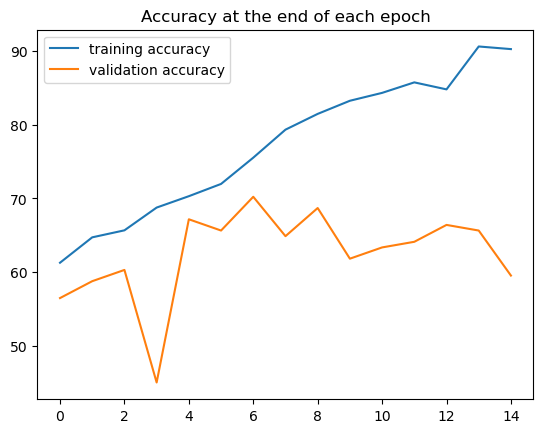

In [20]:
plt.plot([t/842 *100 for t in train_correct], label='training accuracy')
plt.plot([t/131 * 100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

peak accuracy here is about 70%

In [21]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/131:.3f}%')

[tensor(74), tensor(77), tensor(79), tensor(59), tensor(88), tensor(86), tensor(92), tensor(85), tensor(90), tensor(81), tensor(83), tensor(84), tensor(87), tensor(86), tensor(78)]
Test accuracy: 59.542%


In [22]:
print(train_losses)
print(test_losses)
print(train_correct)
print(test_correct)

[tensor(0.4846, grad_fn=<NllLossBackward0>), tensor(1.8952, grad_fn=<NllLossBackward0>), tensor(0.4659, grad_fn=<NllLossBackward0>), tensor(0.7011, grad_fn=<NllLossBackward0>), tensor(0.5094, grad_fn=<NllLossBackward0>), tensor(0.8870, grad_fn=<NllLossBackward0>), tensor(0.7483, grad_fn=<NllLossBackward0>), tensor(0.1816, grad_fn=<NllLossBackward0>), tensor(0.1411, grad_fn=<NllLossBackward0>), tensor(0.4204, grad_fn=<NllLossBackward0>), tensor(0.4887, grad_fn=<NllLossBackward0>), tensor(0.0454, grad_fn=<NllLossBackward0>), tensor(0.1127, grad_fn=<NllLossBackward0>), tensor(0.0034, grad_fn=<NllLossBackward0>), tensor(0.1503, grad_fn=<NllLossBackward0>)]
[tensor(0.3703), tensor(0.6211), tensor(0.7968), tensor(0.1930), tensor(0.2024), tensor(0.7770), tensor(0.0703), tensor(1.3404), tensor(0.6220), tensor(9.6436e-05), tensor(1.0530), tensor(1.5639), tensor(0.9080), tensor(0.0035), tensor(0.5151)]
[tensor(516), tensor(545), tensor(553), tensor(579), tensor(592), tensor(606), tensor(636), te

In [23]:
from torchvision import models

In [24]:
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [25]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [26]:
torch.manual_seed(18)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [27]:
# These are the TRAINABLE parameters:
count_parameters(AlexNetmodel)

 9437184
    1024
    2048
       2
________
 9440258


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

In [29]:
import time
import copy

start_time = time.time()

epochs = 15

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []
best_predictions=[]
epoch_real_values=[]
real_values=[]

epoch_predictions=[]

best_accuracy = 0
best_model_wts = copy.deepcopy(AlexNetmodel.state_dict())

for epoch in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%10 == 0:
            print(f'epoch: {epoch:2}  batch: {b:4} [{10*b:6}/800]  train loss: {loss.item():10.8f}  \
train accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            epoch_predictions.extend(predicted.numpy())
            epoch_real_values.extend(y_test.numpy())
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    
    # Calculate test accuracy
    accuracy = tst_corr * 100 / (131)
    print(f'epoch: {epoch + 1:2}  test loss: {loss.item():10.8f}  test accuracy: {accuracy:7.3f}%')

    # Save the model weights if the current epoch has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_wts = copy.deepcopy(AlexNetmodel.state_dict())
        best_predictions=epoch_predictions
        real_values=epoch_real_values
        
    epoch_predictions=[]
    epoch_real_values=[]

# Load the best model weights
AlexNetmodel.load_state_dict(best_model_wts)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')  # print the time elapsed

epoch:  0  batch:   10 [   100/800]  train loss: 6.29218912  train accuracy:  52.000%
epoch:  0  batch:   20 [   200/800]  train loss: 1.67072678  train accuracy:  57.500%
epoch:  0  batch:   30 [   300/800]  train loss: 4.04683256  train accuracy:  62.000%
epoch:  0  batch:   40 [   400/800]  train loss: 1.69611740  train accuracy:  63.500%
epoch:  0  batch:   50 [   500/800]  train loss: 0.71351433  train accuracy:  65.000%
epoch:  0  batch:   60 [   600/800]  train loss: 1.88841474  train accuracy:  65.333%
epoch:  0  batch:   70 [   700/800]  train loss: 1.11984849  train accuracy:  65.857%
epoch:  0  batch:   80 [   800/800]  train loss: 3.93749738  train accuracy:  65.000%
epoch:  1  test loss: 0.00140294  test accuracy:  60.305%
epoch:  1  batch:   10 [   100/800]  train loss: 0.55472898  train accuracy:  71.000%
epoch:  1  batch:   20 [   200/800]  train loss: 0.31899911  train accuracy:  75.500%
epoch:  1  batch:   30 [   300/800]  train loss: 1.09911692  train accuracy:  77.6

epoch: 11  batch:   10 [   100/800]  train loss: 0.00725225  train accuracy:  90.000%
epoch: 11  batch:   20 [   200/800]  train loss: 0.23878165  train accuracy:  91.000%
epoch: 11  batch:   30 [   300/800]  train loss: 0.13228759  train accuracy:  91.000%
epoch: 11  batch:   40 [   400/800]  train loss: 0.23485748  train accuracy:  92.250%
epoch: 11  batch:   50 [   500/800]  train loss: 0.18306524  train accuracy:  92.000%
epoch: 11  batch:   60 [   600/800]  train loss: 0.18877739  train accuracy:  92.000%
epoch: 11  batch:   70 [   700/800]  train loss: 0.39515728  train accuracy:  92.429%
epoch: 11  batch:   80 [   800/800]  train loss: 0.08276172  train accuracy:  93.250%
epoch: 12  test loss: 3.58885312  test accuracy:  73.282%
epoch: 12  batch:   10 [   100/800]  train loss: 0.07571116  train accuracy:  91.000%
epoch: 12  batch:   20 [   200/800]  train loss: 0.09989591  train accuracy:  93.000%
epoch: 12  batch:   30 [   300/800]  train loss: 0.60588586  train accuracy:  93.6

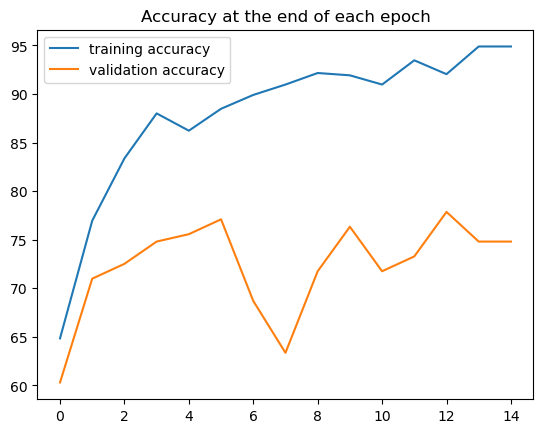

In [30]:
plt.plot([t/842 *100 for t in train_correct], label='training accuracy')
plt.plot([t/131 * 100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

peak accuracy here is about 80%

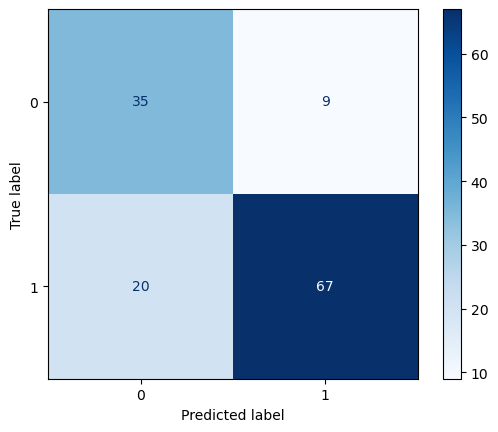

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(real_values, best_predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [40]:
torch.manual_seed(18)
EfficientNetB0Model=models.efficientnet_b0(pretrained=True)

In [41]:
for param in EfficientNetB0Model.parameters():
    param.requires_grad = False

In [42]:
EfficientNetB0Model.classifier=nn.Sequential(nn.Dropout(p=0.2, inplace=True), nn.Linear(1280, 1000), nn.Linear(1000, 100), nn.Linear(100, 2), nn.LogSoftmax(dim=1))

In [43]:
EfficientNetB0Model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [44]:
# These are the TRAINABLE parameters:
count_parameters(EfficientNetB0Model)

 1280000
    1000
  100000
     100
     200
       2
________
 1381302


In [45]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(EfficientNetB0Model.parameters(), lr=0.001)

In [46]:
import time
import copy

start_time = time.time()

epochs = 15

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []
best_predictions=[]
epoch_real_values=[]
real_values=[]

epoch_predictions=[]

best_accuracy = 0
best_model_wts = copy.deepcopy(EfficientNetB0Model.state_dict())

for epoch in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = EfficientNetB0Model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%10 == 0:
            print(f'epoch: {epoch:2}  batch: {b:4} [{10*b:6}/800]  train loss: {loss.item():10.8f}  \
train accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = EfficientNetB0Model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            epoch_predictions.extend(predicted.numpy())
            epoch_real_values.extend(y_test.numpy())
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    
    # Calculate test accuracy
    accuracy = tst_corr * 100 / (131)
    print(f'epoch: {epoch + 1:2}  test loss: {loss.item():10.8f}  test accuracy: {accuracy:7.3f}%')

    # Save the model weights if the current epoch has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_wts = copy.deepcopy(EfficientNetB0Model.state_dict())
        best_predictions=epoch_predictions
        real_values=epoch_real_values
        
    epoch_predictions=[]
    epoch_real_values=[]

# Load the best model weights
EfficientNetB0Model.load_state_dict(best_model_wts)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')  # print the time elapsed

epoch:  0  batch:   10 [   100/800]  train loss: 0.83583593  train accuracy:  59.000%
epoch:  0  batch:   20 [   200/800]  train loss: 1.27526355  train accuracy:  58.000%
epoch:  0  batch:   30 [   300/800]  train loss: 0.52686667  train accuracy:  58.333%
epoch:  0  batch:   40 [   400/800]  train loss: 0.55634773  train accuracy:  59.750%
epoch:  0  batch:   50 [   500/800]  train loss: 0.68986374  train accuracy:  61.600%
epoch:  0  batch:   60 [   600/800]  train loss: 0.57147759  train accuracy:  62.833%
epoch:  0  batch:   70 [   700/800]  train loss: 0.30513707  train accuracy:  63.714%
epoch:  0  batch:   80 [   800/800]  train loss: 0.52584904  train accuracy:  65.250%
epoch:  1  test loss: 0.57174975  test accuracy:  65.649%
epoch:  1  batch:   10 [   100/800]  train loss: 0.63844824  train accuracy:  62.000%
epoch:  1  batch:   20 [   200/800]  train loss: 0.57251871  train accuracy:  66.000%
epoch:  1  batch:   30 [   300/800]  train loss: 0.27957219  train accuracy:  69.0

epoch: 11  batch:   10 [   100/800]  train loss: 0.31460685  train accuracy:  83.000%
epoch: 11  batch:   20 [   200/800]  train loss: 0.27796432  train accuracy:  83.500%
epoch: 11  batch:   30 [   300/800]  train loss: 0.40029192  train accuracy:  81.667%
epoch: 11  batch:   40 [   400/800]  train loss: 0.38612837  train accuracy:  81.000%
epoch: 11  batch:   50 [   500/800]  train loss: 0.31188449  train accuracy:  81.000%
epoch: 11  batch:   60 [   600/800]  train loss: 0.08389027  train accuracy:  81.333%
epoch: 11  batch:   70 [   700/800]  train loss: 0.25959793  train accuracy:  80.571%
epoch: 11  batch:   80 [   800/800]  train loss: 0.59424675  train accuracy:  81.250%
epoch: 12  test loss: 1.32384026  test accuracy:  61.832%
epoch: 12  batch:   10 [   100/800]  train loss: 0.19850950  train accuracy:  86.000%
epoch: 12  batch:   20 [   200/800]  train loss: 0.28148767  train accuracy:  81.000%
epoch: 12  batch:   30 [   300/800]  train loss: 0.69354212  train accuracy:  79.3

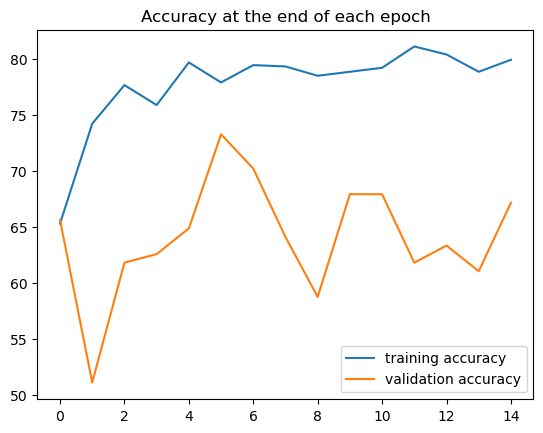

In [47]:
plt.plot([t/842 *100 for t in train_correct], label='training accuracy')
plt.plot([t/131 * 100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

peak accuracy here is about 75%

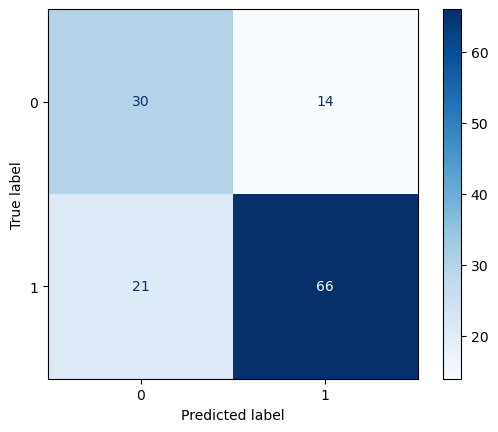

In [48]:
# Generate confusion matrix
cm = confusion_matrix(real_values, best_predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [49]:
torch.manual_seed(18)
EfficientNetB3Model=models.efficientnet_b3(pretrained=True)
EfficientNetB3Model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [50]:
for param in EfficientNetB3Model.parameters():
    param.requires_grad = False

In [51]:
EfficientNetB3Model.classifier=nn.Sequential(nn.Dropout(p=0.3, inplace=True), nn.Linear(1536, 1000), nn.Linear(1000,100), nn.Linear(100,2), nn.LogSoftmax(dim=1))

In [52]:
optimizer=torch.optim.Adam(EfficientNetB3Model.parameters(),lr=0.001)

In [53]:
EfficientNetB3Model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [54]:
import time
import copy

start_time = time.time()

epochs = 15

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []
best_predictions=[]
epoch_real_values=[]
real_values=[]

epoch_predictions=[]

best_accuracy = 0
best_model_wts = copy.deepcopy(EfficientNetB3Model.state_dict())

for epoch in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = EfficientNetB3Model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%10 == 0:
            print(f'epoch: {epoch:2}  batch: {b:4} [{10*b:6}/800]  train loss: {loss.item():10.8f}  \
train accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = EfficientNetB3Model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            epoch_predictions.extend(predicted.numpy())
            epoch_real_values.extend(y_test.numpy())
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    
    # Calculate test accuracy
    accuracy = tst_corr * 100 / (131)
    print(f'epoch: {epoch + 1:2}  test loss: {loss.item():10.8f}  test accuracy: {accuracy:7.3f}%')

    # Save the model weights if the current epoch has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_wts = copy.deepcopy(EfficientNetB3Model.state_dict())
        best_predictions=epoch_predictions
        real_values=epoch_real_values
        
    epoch_predictions=[]
    epoch_real_values=[]

# Load the best model weights
EfficientNetB3Model.load_state_dict(best_model_wts)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')  # print the time elapsed

epoch:  0  batch:   10 [   100/800]  train loss: 0.88997877  train accuracy:  42.000%
epoch:  0  batch:   20 [   200/800]  train loss: 0.35352722  train accuracy:  55.000%
epoch:  0  batch:   30 [   300/800]  train loss: 0.63145304  train accuracy:  58.000%
epoch:  0  batch:   40 [   400/800]  train loss: 0.65432900  train accuracy:  59.000%
epoch:  0  batch:   50 [   500/800]  train loss: 0.57257456  train accuracy:  61.800%
epoch:  0  batch:   60 [   600/800]  train loss: 0.49969792  train accuracy:  62.667%
epoch:  0  batch:   70 [   700/800]  train loss: 0.54076058  train accuracy:  64.000%
epoch:  0  batch:   80 [   800/800]  train loss: 0.93313676  train accuracy:  64.750%
epoch:  1  test loss: 0.96642983  test accuracy:  67.176%
epoch:  1  batch:   10 [   100/800]  train loss: 0.58459842  train accuracy:  80.000%
epoch:  1  batch:   20 [   200/800]  train loss: 0.31587163  train accuracy:  77.500%
epoch:  1  batch:   30 [   300/800]  train loss: 0.37865359  train accuracy:  77.0

epoch: 11  batch:   10 [   100/800]  train loss: 0.71436894  train accuracy:  77.000%
epoch: 11  batch:   20 [   200/800]  train loss: 0.40171489  train accuracy:  78.000%
epoch: 11  batch:   30 [   300/800]  train loss: 0.23568234  train accuracy:  79.000%
epoch: 11  batch:   40 [   400/800]  train loss: 0.33233896  train accuracy:  79.750%
epoch: 11  batch:   50 [   500/800]  train loss: 0.46116334  train accuracy:  77.400%
epoch: 11  batch:   60 [   600/800]  train loss: 0.30632681  train accuracy:  77.833%
epoch: 11  batch:   70 [   700/800]  train loss: 0.25285709  train accuracy:  78.286%
epoch: 11  batch:   80 [   800/800]  train loss: 0.60084242  train accuracy:  78.500%
epoch: 12  test loss: 1.78298426  test accuracy:  63.359%
epoch: 12  batch:   10 [   100/800]  train loss: 0.12426083  train accuracy:  87.000%
epoch: 12  batch:   20 [   200/800]  train loss: 0.32264709  train accuracy:  84.000%
epoch: 12  batch:   30 [   300/800]  train loss: 0.41423836  train accuracy:  81.3

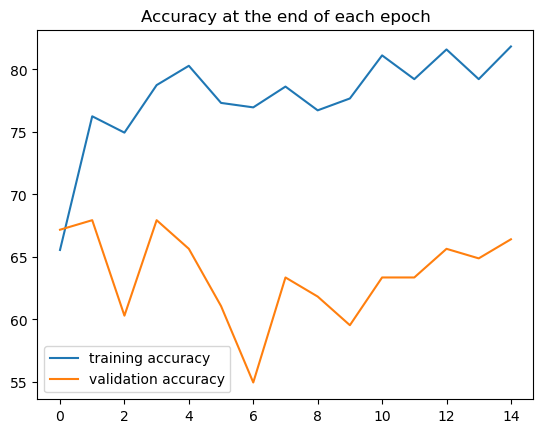

In [55]:
plt.plot([t/842 *100 for t in train_correct], label='training accuracy')
plt.plot([t/131 * 100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

peak accuracy here is about 68% 

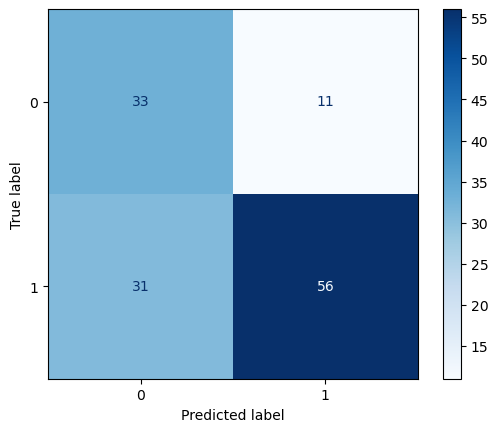

In [56]:
# Generate confusion matrix
cm = confusion_matrix(real_values, best_predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## We can conclude now that AlexNet achieves the best accuracy which is about 80%

In [57]:
torch.save(AlexNetmodel.state_dict(), 'ArtAuthAlexNetModel.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


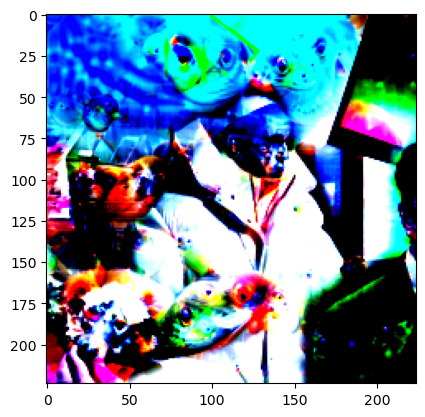

In [65]:
x = 1
im = test_data[x][0]
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [60]:
AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 AI


In [64]:
print(im.numpy().shape)

(3, 224, 224)
